### __Imports and installs__

In [ ]:
!pip install grad-cam
!pip install timm
!git clone https://github.com/ylhz/tf_to_pytorch_model.git

import requests
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import skimage
from skimage.feature import peak_local_max

import timm
import pandas as pd


### __Dataset__

In [ ]:
def read_images_and_labels(images_folder_path, csv_file_path):
    labels_df = pd.read_csv(csv_file_path)
    labels_dict = pd.Series(labels_df.TrueLabel.values, index=labels_df.ImageId).to_dict()

    images = []
    labels = []

    for filename in os.listdir(images_folder_path):
        if filename.endswith(".png") and filename != "362e4ac62cf888f4.png" and filename != "bd3617fcc985fe31.png":
            image_id = filename.replace('.png', '')
            img_path = os.path.join(images_folder_path, filename)

            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            images.append(img)

            if image_id in labels_dict:
                labels.append(labels_dict[image_id])
            else:
                labels.append(None)  # (should not happen)

    images_array = np.array(images)
    labels_array = np.array(labels)

    return images_array, labels_array

In [ ]:
folder_path = 'tf_to_pytorch_model/dataset/images'
csv_file_path = 'tf_to_pytorch_model/dataset/dev_dataset.csv'
X, y = read_images_and_labels(folder_path, csv_file_path)

print(X.shape, y.shape)

y -= 1
y_long = torch.tensor(y, dtype=torch.long)
one_hot_y = F.one_hot(y_long, num_classes = 1000)
one_hot_y = one_hot_y.float()

(998, 299, 299, 3) (998,)


In [ ]:
# Load ImageNet class labels
LABELS_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
labels_response = requests.get(LABELS_URL)
labels_dict = labels_response.json()

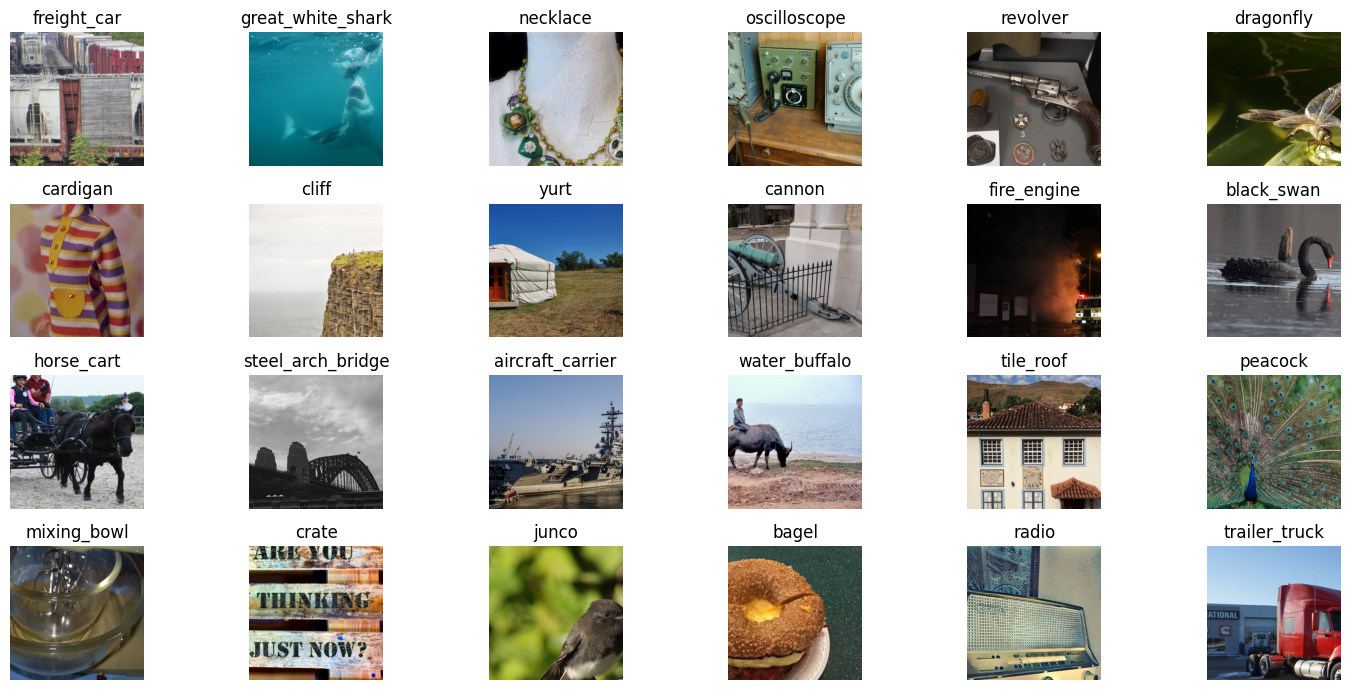

In [ ]:
plt.figure(figsize=(15, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X[i])
    plt.title(labels_dict[str(y[i])][1])
    plt.axis('off')
plt.gcf().tight_layout()


### __Preprocessing__

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def resize_image(input_images, model_name):
    model_shapes = {
        "squeezenet": (224, 224),
        "inceptionv4": (299, 299),
        "resnet50": (224, 224),
        "adv_inceptionv3": (299, 299)
    }

    target_shape = model_shapes.get(model_name)

    if target_shape is None:
        raise ValueError("Invalid model name. Please provide a valid model name.")

    # Check if input is a batch of images (4-dimensional)
    if len(input_images.shape) == 4:
        resized_images = []
        for img in input_images:
            # Resize each image in the batch
            resized_img = skimage.transform.resize(img, (*target_shape, 3), anti_aliasing=True)
            resized_images.append(resized_img)
        resized_images = np.array(resized_images)
        return resized_images
    # If input is a single image (3-dimensional)
    elif len(input_images.shape) == 3:
        resized_image = skimage.transform.resize(input_images, (*target_shape, 3), anti_aliasing=True)
        return resized_image
    else:
        raise ValueError("Input images should have 3 or 4 dimensions.")

class Preprocessing_Transform:
    def __init__(self, mean, std, model_name, device):
        self.mean = mean
        self.std = std
        self.model_name = model_name
        self.device = device

    def __call__(self, img):
        img = resize_image(img, self.model_name)
        if len(img.shape)==3:
          img_normalized = (img - np.array(self.mean)[None, None, :]) / np.array(self.std)[None, None, :] # Normalize
          return torch.tensor(img_normalized, dtype=torch.float32).permute(2, 0, 1).to(self.device)
        elif len(img.shape)==4:
          img_normalized = (img - np.array(self.mean)[None, None, None, :]) / np.array(self.std)[None, None, None, :] # Normalize
          return torch.tensor(img_normalized, dtype=torch.float32).permute(0, 3, 1, 2).to(self.device)

class Depreprocessing_Transform:
    def __init__(self, mean, std, model_name):
        self.mean = mean
        self.std = std
        self.model_name = model_name

    def __call__(self, tensor_img):
        if len(tensor_img.shape)==3:
          img_normalized = tensor_img.permute(1,2,0).detach().cpu().numpy()
          img = (img_normalized * np.array(self.std)[None, None, :]) + np.array(self.mean)[None, None, :] # Denormalize
          img = resize_image(img, self.model_name)
          return img
        elif len(tensor_img.shape)==4:
          img_normalized = tensor_img.permute(0, 2, 3, 1).detach().cpu().numpy()
          img = (img_normalized * np.array(self.std)[None, None, None, :]) + np.array(self.mean)[None, None, None, :] # Denormalize
          img = resize_image(img, self.model_name)
          return img

class Normalized_Clamp:
    def __init__(self, mean, std, device):
        self.mean = torch.Tensor(mean).to(device)
        self.std = torch.Tensor(std).to(device)

    def __call__(self, normalized_tensor):
        low = (-self.mean/self.std).view(3,1,1).expand_as(normalized_tensor)
        high = ((1-self.mean)/self.std).view(3,1,1).expand_as(normalized_tensor)
        return torch.clamp(normalized_tensor, low, high)

### __Models__

In [ ]:
def get_model(model_name, device):

  if model_name == "resnet50":

    # Load the model
    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
    model.to(device)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False

    # Model in test mode
    model.eval()
    return model

  if model_name == "squeezenet":

    # Load the model
    model = torchvision.models.squeezenet1_1(weights=torchvision.models.SqueezeNet1_1_Weights.DEFAULT)
    model.to(device)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False

    # Model in test mode
    model.eval()
    return model

  if model_name == "inceptionv4":

    # Load Model
    model = timm.create_model('inception_v4', pretrained=True)
    model.to(device)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False

    # Model in test mode
    model.eval()
    return model

  if model_name == "adv_inceptionv3":

    # Load the model
    model = timm.create_model('adv_inception_v3', pretrained=True)
    model.to(device)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False

    # Model in test mode
    model.eval()
    return model

def get_module_by_name(model, module_name):
    for name, module in model.named_modules():
        if name == module_name:
            return module
    return None

def get_target_layer(model_name, model):

  if model_name == "resnet50":
    return [model.layer4[-1]]

  if model_name == "squeezenet":
    return [model.features[-1]]

  if model_name == "inceptionv4":
    return [model.features[-1]]

  if model_name == "adv_inceptionv3":
    return [get_module_by_name(model, 'Mixed_7c')]

### __Class Activation Maps__

In [ ]:
targets = [ClassifierOutputTarget(class_id) for class_id in y]

squeezenet_cpu = get_model("squeezenet", "cpu")
resnet50_cpu = get_model("resnet50", "cpu")
inceptionv4_cpu = get_model("inceptionv4", "cpu")
adv_inceptionv3_cpu = get_model("adv_inceptionv3", "cpu")


input_tensor_squeezenet = Preprocessing_Transform(mean, std, "squeezenet", "cpu")(X[:25]).detach().requires_grad_(True)

# Construct the CAM object once, and then re-use it on many images:
cam_squeezenet = GradCAMPlusPlus(model=squeezenet_cpu, target_layers=get_target_layer("squeezenet", squeezenet_cpu))

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_squeezenet = cam_squeezenet(input_tensor=input_tensor_squeezenet, targets=targets)



input_tensor_inceptionv4 = Preprocessing_Transform(mean, std, "inceptionv4", "cpu")(X[:25]).detach().requires_grad_(True)

# Construct the CAM object once, and then re-use it on many images:
cam_inceptionv4 = GradCAMPlusPlus(model=inceptionv4_cpu, target_layers=get_target_layer("inceptionv4", inceptionv4_cpu))

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_inceptionv4 = cam_inceptionv4(input_tensor=input_tensor_inceptionv4, targets=targets)



input_tensor_resnet50 = Preprocessing_Transform(mean, std, "resnet50", "cpu")(X[:25]).detach().requires_grad_(True)

# Construct the CAM object once, and then re-use it on many images:
cam_resnet50 = GradCAMPlusPlus(model=resnet50_cpu, target_layers=get_target_layer("resnet50", resnet50_cpu))

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_resnet50 = cam_resnet50(input_tensor=input_tensor_resnet50, targets=targets)



input_tensor_adv_inceptionv3 = Preprocessing_Transform(mean, std, "adv_inceptionv3", "cpu")(X[:25]).detach().requires_grad_(True)

# Construct the CAM object once, and then re-use it on many images:
cam_adv_inceptionv3 = GradCAMPlusPlus(model=adv_inceptionv3_cpu, target_layers=get_target_layer("adv_inceptionv3", adv_inceptionv3_cpu))

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_adv_inceptionv3 = cam_resnet50(input_tensor=input_tensor_adv_inceptionv3, targets=targets)

In [ ]:
def print_cams(grayscale_cams, model_name, images):

  resized_images = resize_image(images, model_name)

  grayscale_cams = [cam.squeeze() for cam in grayscale_cams]  # Removing any extra dimensions

  num_images_to_display = 25

  columns = 5  # Number of columns in the grid
  rows = math.ceil(num_images_to_display / columns)  # Calculate the number of rows needed

  fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3))  # Adjust figsize as needed
  axes = axes.flatten()  # Flatten the axes array for easy indexing

  for i in range(num_images_to_display):
      if i < len(images):

          img = resized_images[i]

          # Get the corresponding CAM
          cam_image = grayscale_cams[i]

          # Overlay CAM on the image
          visualization = show_cam_on_image(img, cam_image, use_rgb=True)

          ax = axes[i]
          ax.imshow(visualization)
          ax.axis('off')
      else:
          break  # Break if there are no more images

  # Hide any unused axes if there are fewer images than subplots
  for ax in axes[num_images_to_display:]:
      ax.axis('off')

  plt.show()

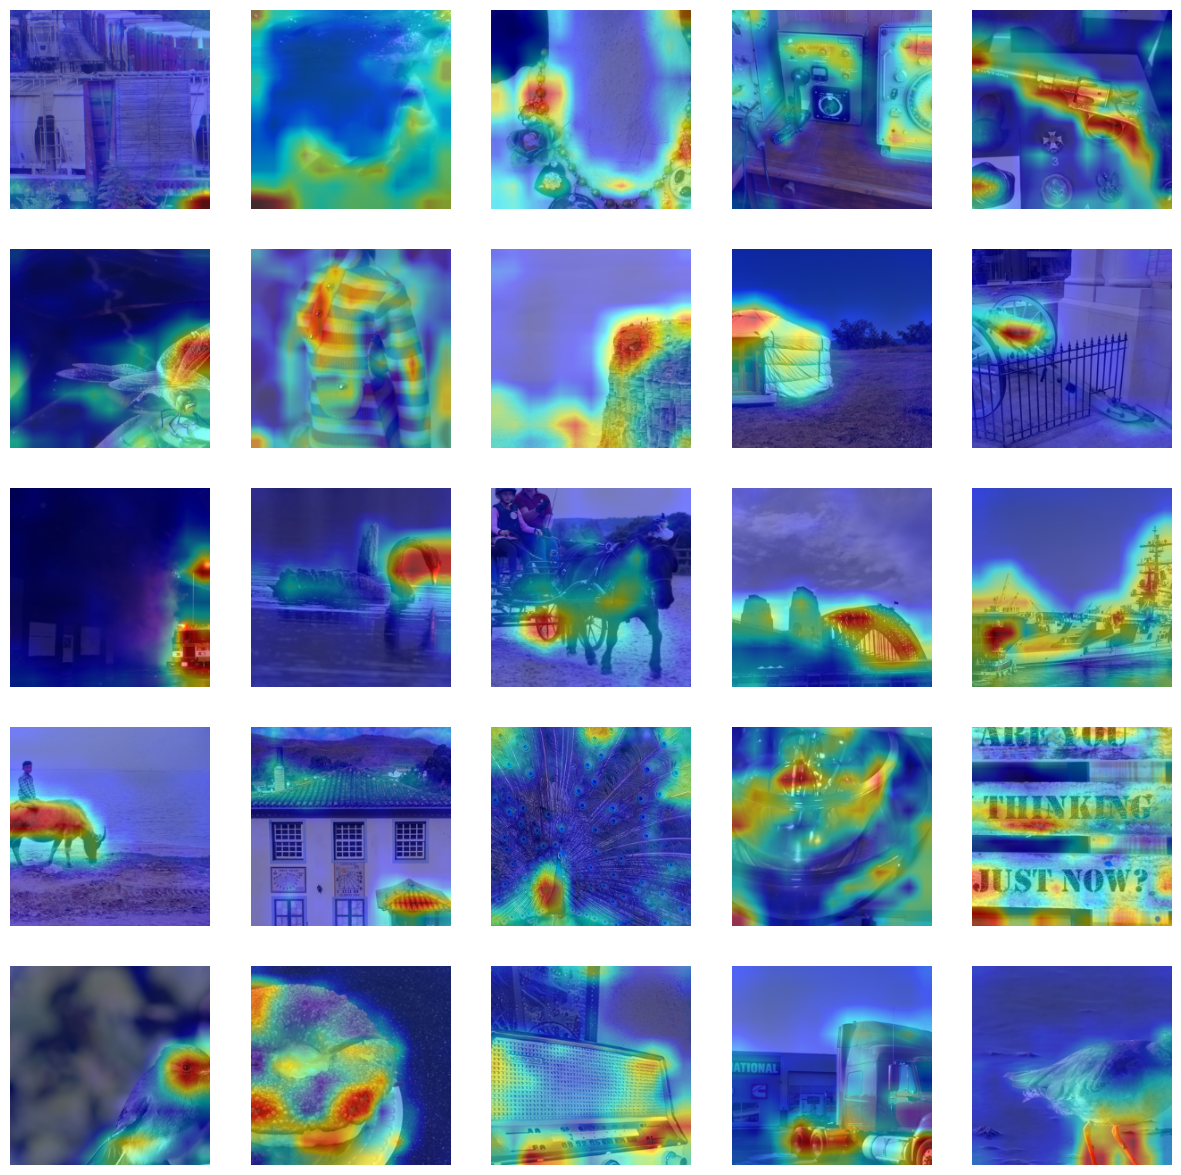

In [ ]:
print_cams(grayscale_cam_squeezenet, "squeezenet", X[:25])

In [ ]:
print_cams(grayscale_cam_inceptionv4, "inceptionv4", X[:25])

In [ ]:
print_cams(grayscale_cam_resnet50, "resnet50", X[:25])

In [ ]:
print_cams(grayscale_cam_adv_inceptionv3, "adv_inceptionv3", X[:25])

### __Local Maxima__

In [ ]:
def get_centers(M, ratio_threshold = 0.6, min_distance = 20):
    # Find coordinates of local maxima
    coordinates = peak_local_max(M, num_peaks=3, exclude_border=False, min_distance=min_distance)

    if len(coordinates)==0:
      global_max_index = np.unravel_index(np.argmax(M), M.shape)
      return np.array([global_max_index])

    # Extract the values at these coordinates
    maxima_values = M[coordinates[:, 0], coordinates[:, 1]]

    # Determine the highest value among the maxima
    highest_maxima_value = max(maxima_values)

    # Filter coordinates based on the threshold
    filtered_coordinates = coordinates[maxima_values >= ratio_threshold * highest_maxima_value]
    return filtered_coordinates

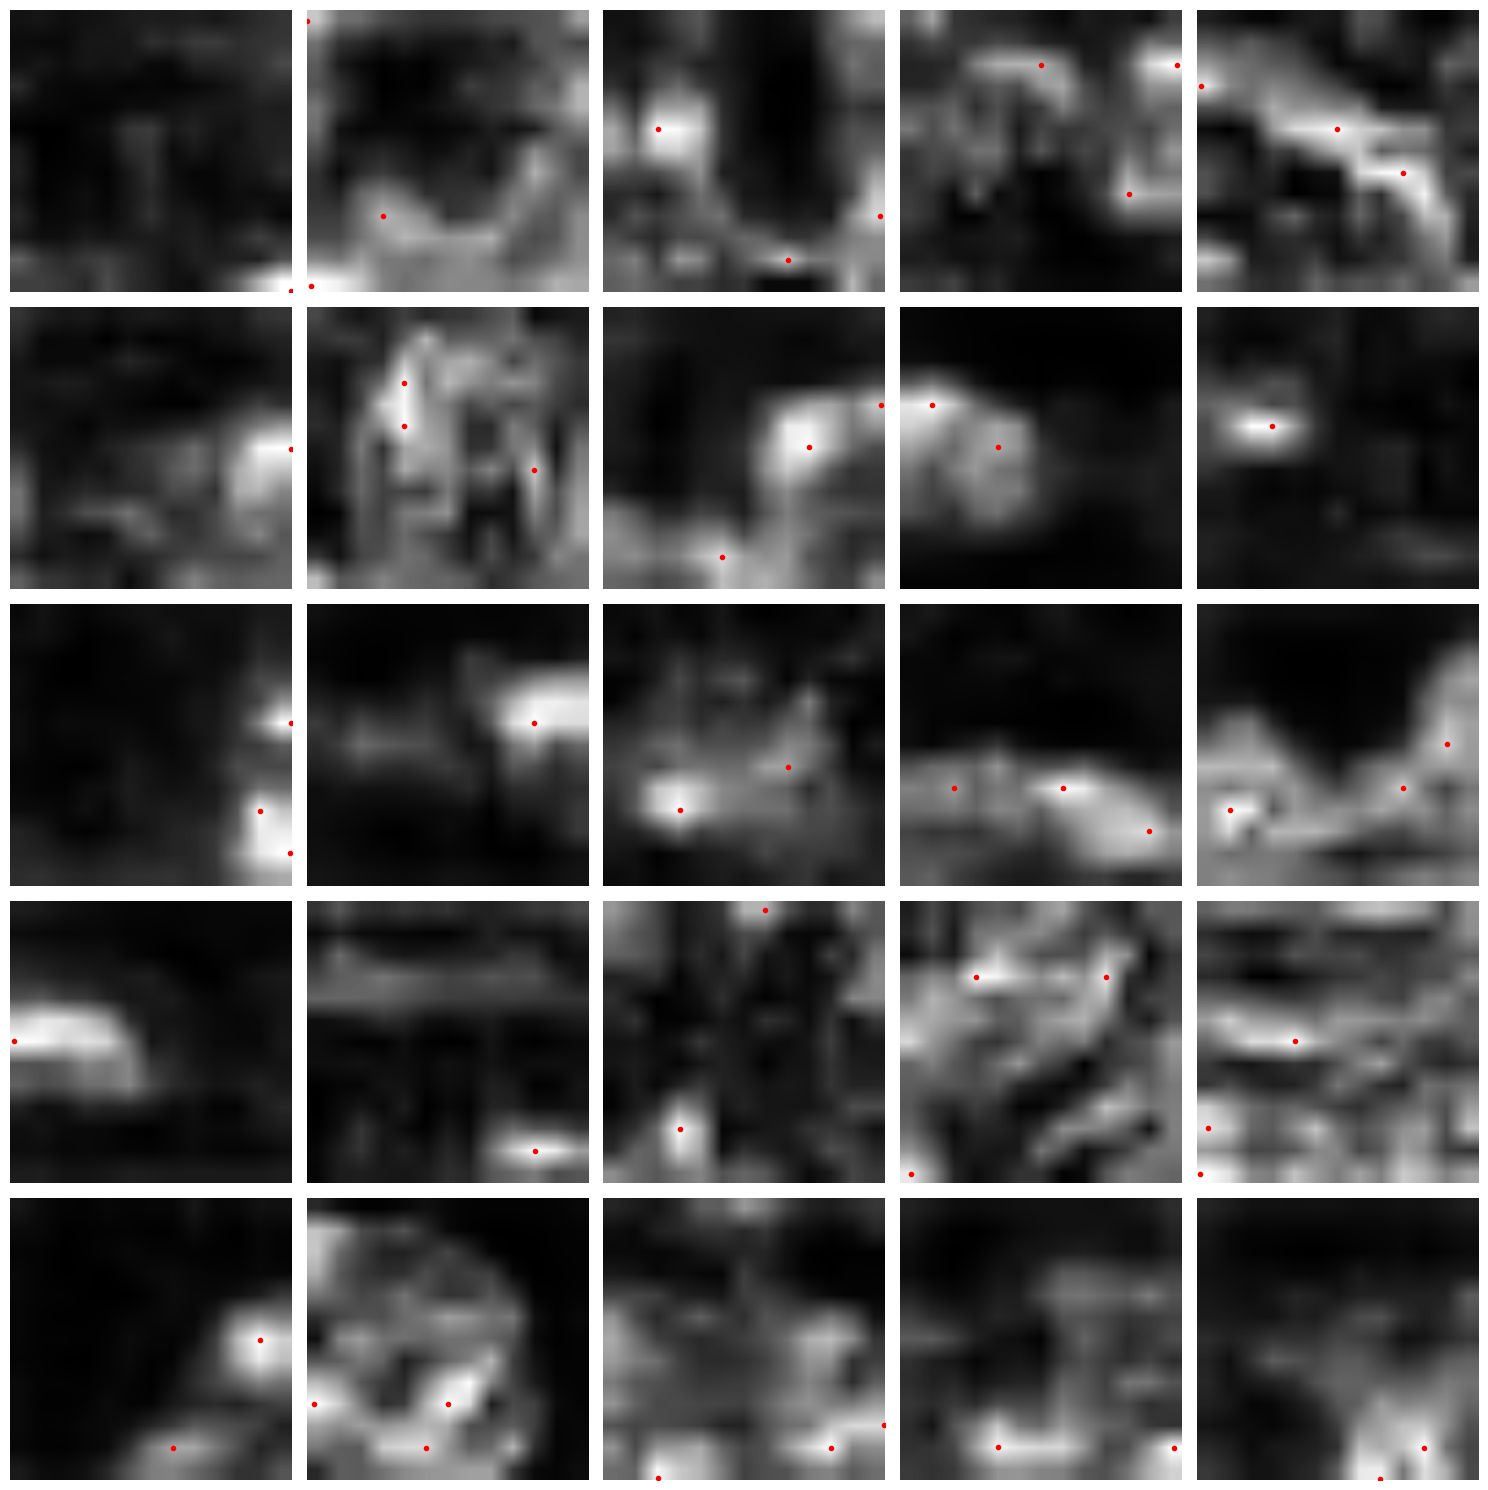

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    M = grayscale_cam_squeezenet[i]

    # Plot the grayscale cam
    ax.imshow(M, cmap='gray')

    filtered_coordinates = get_centers(M, ratio_threshold = 0.6, min_distance = 20)

    # Plot the filtered coordinates on the images
    ax.plot(filtered_coordinates[:, 1], filtered_coordinates[:, 0], 'r.')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### __Main algorithm__

In [ ]:
def ADP(x_clean, y_true, model_name, model, ratio_threshold, min_distance, eps, T, alpha, beta, m, mean, std, cam_method = "normal", momentum = None, device = "cuda"):

  y_true = y_true.to(device)

  if momentum != None:
    use_momentum = True
  else:
    use_momentum = False

  target_layer = get_target_layer(model_name, model)

  if cam_method == "normal":
    cam = GradCAM(model=model, target_layers=target_layer)

  elif cam_method == "++":
    cam = GradCAMPlusPlus(model=model, target_layers=target_layer)

  targets = [ClassifierOutputTarget(torch.argmax(y_true))]

  x_adv = torch.clone(x_clean).detach().requires_grad_(True)

  W, H = x_clean.shape[1], x_clean.shape[2]

  criterion = torch.nn.CrossEntropyLoss()

  normalized_clamp = Normalized_Clamp(mean, std, device)

  for t in range(0, T):
    x_adv.requires_grad_(True)
    g = 0
    if use_momentum:
      previous_g = 0
    M = cam(input_tensor=x_adv, targets=targets)

    centers = get_centers(M[0], ratio_threshold, min_distance)

    for center in centers:

      for k in range(1, m+1):
        x1 = int(max(center[0]-beta*k, 0))
        x2 = int(min(center[0]+beta*k, W))
        y1 = int(max(center[1]-beta*k, 0))
        y2 = int(min(center[1]+beta*k, H))

        x_drop = torch.clone(x_adv).detach()
        x_drop.data[:, x1:x2, y1:y2] = x_clean.data[:, x1:x2, y1:y2]
        x_drop = x_drop.detach()
        x_drop.requires_grad_(True)

        loss = criterion(model(x_drop)[0], y_true)
        loss.backward()

        grad = x_drop.grad.data
        g += grad

        x_drop.grad.zero_()

    g *= 1/(len(centers)*m)

    if use_momentum:
      g = momentum * previous_g + g / torch.mean(torch.abs(g), dim = (1,2,3), keepdim=True)

    x_adv_max = x_clean + eps
    x_adv_min = x_clean - eps

    with torch.no_grad():

      x_adv_max = normalized_clamp(x_adv_max)
      x_adv_min = normalized_clamp(x_adv_min)

      g_sign = g.sign()
      perturbed_x_adv = x_adv + alpha * g_sign
      x_adv = torch.max(torch.min(perturbed_x_adv, x_adv_max), x_adv_min)

      previous_g = torch.clone(g)

  return x_adv

#### Example use

In [ ]:
x_clean = Preprocessing_Transform(mean, std, "squeezenet", "cpu")(X[0]).unsqueeze(0)
y_true = one_hot_y[0]

x_adv = ADP(x_clean, y_true, "squeezenet", squeezenet_cpu, ratio_threshold=0.6, min_distance=20, eps=0.274, T=10, alpha=0.5, beta=15, m=5, mean=mean, std=std, cam_method = "++", momentum = 0.8, device = "cpu")

In [ ]:
transfer_x_adv = Preprocessing_Transform(mean, std, "inceptionv4", "cpu")(Depreprocessing_Transform(mean, std, "squeezenet")(x_adv.squeeze()))

In [ ]:
y_pred_squeezenet_before = torch.argmax(torch.nn.functional.softmax(squeezenet_cpu(x_clean)[0], dim=0))
y_pred_inceptionv4_before = torch.argmax(torch.nn.functional.softmax(inceptionv4_cpu(x_clean)[0], dim=0))

y_pred_squeezenet_after = torch.argmax(torch.nn.functional.softmax(squeezenet_cpu(x_adv)[0], dim=0))
y_pred_inceptionv4_after = torch.argmax(torch.nn.functional.softmax(inceptionv4_cpu(transfer_x_adv.unsqueeze(0))[0], dim=0))

print("True class: ", labels_dict[str(int(torch.argmax(one_hot_y[0])))][1])

print("Initial predicted class, Attack model: ", labels_dict[str(int(y_pred_squeezenet_before))][1])
print("Initial predicted class, Transfer model: ", labels_dict[str(int(y_pred_inceptionv4_before))][1])

print("New predicted class, Attack model: ", labels_dict[str(int(y_pred_squeezenet_after))][1])
print("New predicted class, Transfer model: ", labels_dict[str(int(y_pred_inceptionv4_after))][1])

True class:  freight_car
Initial predicted class, Attack model:  streetcar
Initial predicted class, Transfer model:  crate
New predicted class, Attack model:  castle
New predicted class, Transfer model:  fire_engine


### __Statistics__

In [ ]:
def get_accuracy(model, dataset_X, dataset_y):
  with torch.no_grad():
    y_pred = np.array(model(dataset_X).argmax(dim=1).detach().cpu())

  accuracy = np.mean((y_pred == dataset_y))

  return accuracy


In [ ]:
squeezenet_cuda = get_model("squeezenet", "cuda")
get_accuracy(squeezenet_cuda, Preprocessing_Transform(mean, std, "squeezenet", "cuda")(X), y)

0.685370741482966

TODO : clamp avec bonnes valeurs et adapter eps en conséquence (done!); chercher les 1000 images et gérer le pb de la bande en bas (done!); chercher autres modèles (cf papier), Essayer moyenner x_adv sur différents modèles
IDEES AMELIO : rescale dans algo (done), gradCAM (RDFIA) en + de gradCAM++; threshold au lieu de région carrée pour régions dropout, tester en mettant le gradient à 0 dans les régions dropped out

In [ ]:
X_adv_dataset = []
input_dataset = Preprocessing_Transform(mean, std, "squeezenet", "cuda")(X)

for i in tqdm(range(len(X))):
    x_clean = input_dataset[i].unsqueeze(0)

    y_true = one_hot_y[i]

    # Generate the adversarial example
    x_adv = ADP(x_clean, y_true, "squeezenet", squeezenet_cuda, ratio_threshold=0.6, min_distance=20, eps=0.274,
                T=10, alpha=0.5, beta=15, m=5, mean=mean, std=std, cam_method="++", momentum=0.8, device = "cuda")


    X_adv_dataset.append(x_adv.squeeze())

X_adv_dataset_tensor = torch.stack(X_adv_dataset)


 62%|██████▏   | 617/998 [09:17<06:01,  1.05it/s]

In [ ]:
get_accuracy(X_adv_dataset_tensor, y)